In [3]:
#install.packages('RPostgres')

In [29]:
library('DBI')
library('ggplot2')

In [5]:
db <- 'dbap-2021-t14'  #provide the name of your db
host_db <- '178.62.41.209'
db_port <- 5432  # or any other port specified by the DBA
db_user <- 'postgres'
db_password <- 'gmd5PNXNhjGvjp'
con <- dbConnect(RPostgres::Postgres(), dbname = db, host=host_db, port=db_port, user=db_user, password=db_password)  

In [36]:
dbListTables(con) 

[1] "mapping"     "mappingfile" "gdp"         "country"     "happiness"

In [120]:
# values over 90 are possibly bad values (from jpg)
q <- dbSendQuery(con, "select country_code, count(1) a0, sum(counter) a1, sum(value * counter) a2, sum(value * value * counter) a3
	from mapping where value < 90 group by country_code")
result <- dbFetch(q)
dbClearResult(q)

In [121]:
# https://worldpopulationreview.com/country-rankings/happiest-countries-in-the-world
q2 <- dbSendQuery(con, "select code, value from happiness")
r2 <- dbFetch(q2)
dbClearResult(q2)
r2 <- subset(r2, code != 'NA')
result <- merge(result, r2, by.x='country_code', by.y='code')

In [122]:
result$n = result$a1
result$mean = result$a2/result$n
sqr <- function(x) { return (x*x) }
result$var = (result$a3/result$n - sqr(result$mean)) 
result$sd = sqrt(result$var)

In [123]:
head(result)

,country_code,a0,a1,a2,a3,value,n,mean,var,sd
,<chr>,<int64>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,AFG,1937,3986052,24349568,726194912,2.567,3986052,6.108693,144.867873,12.036107
2,ALB,667,1043405,20984822,772739520,4.883,1043405,20.111866,336.106864,18.333218
3,ARE,169,21851,94394,562696,6.791,21851,4.319894,7.090016,2.662708
4,ARG,13315,93978967,1187252606,37222542568,5.975,93978967,12.633174,236.476043,15.377778
5,ARM,579,1095167,13453548,436499454,4.677,1095167,12.284472,247.660608,15.737236
6,AUS,18597,200807404,1965503300,69243699900,7.223,200807404,9.788002,249.021442,15.780413


`geom_smooth()` using formula 'y ~ x'



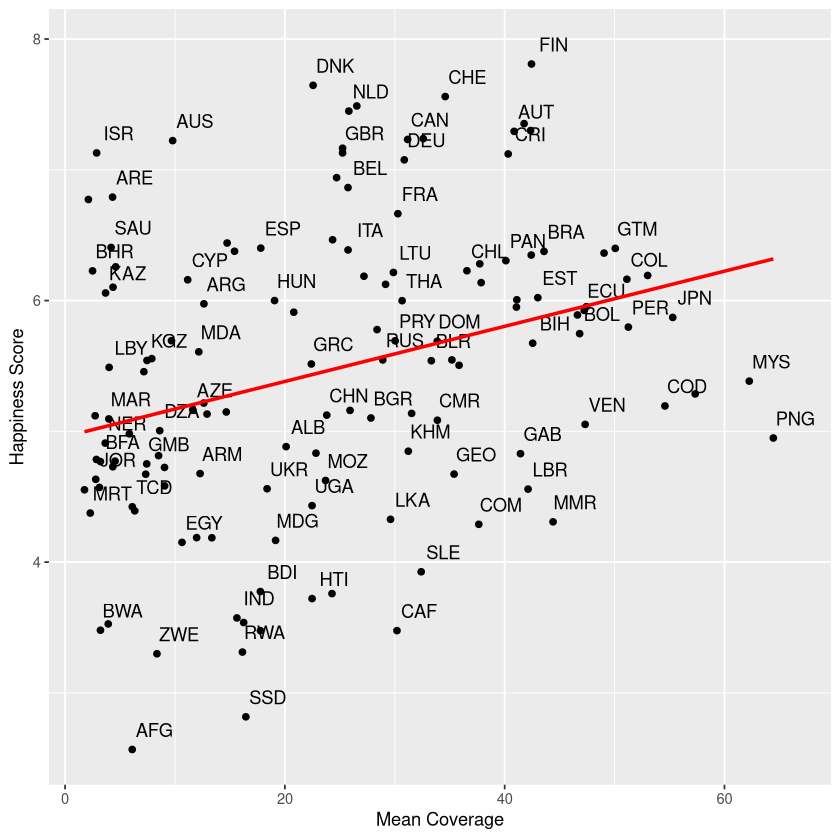

In [130]:
ggplot(result, aes(x=mean, y=value)) + 
   geom_point() +
   geom_text(label=result$country_code, 
    nudge_x = 2, nudge_y = 0.15, 
    check_overlap = T) +
 geom_smooth(method=lm , color="red", fill="#69b3a2", se=FALSE) +
  xlab('Mean Coverage') +
  ylab('Happiness Score')


In [128]:
cor.test(result$mean, result$value)


	Pearson's product-moment correlation

data:  result$mean and result$value
t = 3.6748, df = 136, p-value = 0.0003415
alternative hypothesis: true correlation is not equal to 0
95 percent confidence interval:
 0.1404936 0.4452843
sample estimates:
      cor 
0.3005426 
